## DeepArt Proyecto curso Inteligencia Artificial


Importamos las librerias necesarias:

In [1]:
import os #estamos usando python3.9
import tensorflow as tf #version 2.6.0 #versión keras 2.6, no usar la versión keras 2.7 hasta que solucionen error de compatibilidad.
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

Escogemos las imágenes a usar, donde content es la imagen a transformar y style es el estilo a utilizar.

In [2]:
content = 'entrada/prueba7.jpg' #para utilizar una imagen suya guardela en la carpeta entrada del directorio
style = 'estilos/crepusculoenvenecia.jpg' #para utilizar una imagen suya guardela en la carpeta salida del directorio

Definimos una función que carga una imagen y le limita su dimensión, en este caso 512 o 1024,

In [3]:
def Cargar(path):
    dimM = 1024 #512 #dependiendo de la potencia de su maquina puede experimentar con mayor resolución, pero requerira de imágenes base de alta resolución
    img = tf.io.read_file(path) #utilizamos funciones de TF para leer el archivo
    img = tf.image.decode_image(img, channels=3) #función que identifica el formato de la imagen y utiliza la operación para convertirla en un tensor
    img = tf.image.convert_image_dtype(img, tf.float32) #transforma la imagen en un dtype
    shape = tf.cast(tf.shape(img)[:-1], tf.float32) #calculamos la forma del tensor
    dimL = max(shape)
    scale = dimM / dimL #definimos la escala a trabajar
    new_shape = tf.cast(shape * scale, tf.int32) #utilizamos los datos calculados para definir la nueva forma
    img = tf.image.resize(img, new_shape) #reajustamos las dimensiones
    img = img[tf.newaxis, :]
    return img #devolvemos la imagen 

Definimos una función que muestra la imagen,

In [4]:
def Mostrar(image, title=None):
    if len(image.shape) > 3: #removemos las dimensiones de tamaño 1 del tensor si es que es muy grande
        image = tf.squeeze(image, axis=0)
    plt.imshow(image) #función de matplotlib que muestra imagenes
    if title:
        plt.title(title)

Mostramos las imágenes seleccionadas,

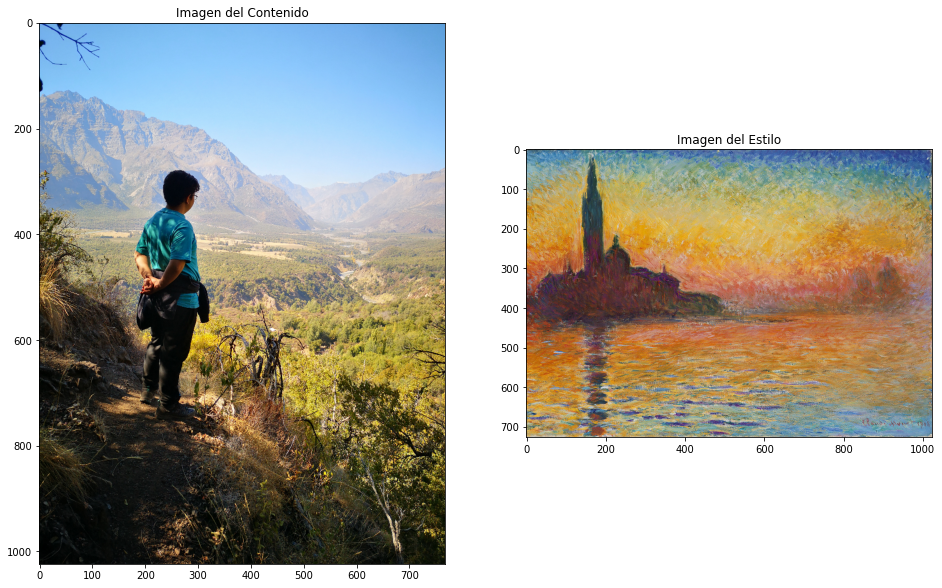

In [5]:
content_imagen = Cargar(content)
style_imagen = Cargar(style)
mpl.rcParams['figure.figsize'] = (16, 16) #definimos los tamaños y algunos ajustes de los grafos
mpl.rcParams['axes.grid'] = False
plt.subplot(1, 2, 1)
Mostrar(content_imagen, 'Imagen del Contenido')
plt.subplot(1, 2, 2)
Mostrar(style_imagen, 'Imagen del Estilo')

#  Proceso:
Utilizando las capas intermedias del modelo, obtenemos la representación de lo que es la imágen contenido (imagen a transformar) y la imagen estilo (estilo a replicar). Es entonces como a partir de la capa de entrada a la red neuronal tendremos las primeras activaciones que hacen alusión a las características de bajo nivel como lo son los bordes y/o texturas. A medida que se va adentrando en la red, tendremos capas que representan características de nivel superior como lo son partes de objetos (sombreros, montañas, pasto,etc). Para este caso en particular usaremos una arquitectura de red neuronal ya entrenada que es la  [VGG19](https://keras.io/api/applications/vgg/ "VGG19"). esta una red de clasificación de imagenes. 


Para cargar el modelos notamos que TensorFlow en su versión 2.6.0 tiene una función ya preestablecida que carga el modelo.

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_imagen*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

Utilizamos una función de TensorFlow que identifica los elementos destacados de las imágenes utilizando el modelo VGG19

In [7]:
top5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in top5]

[('alp', 0.4177019),
 ('valley', 0.3225861),
 ('mountain_bike', 0.15394336),
 ('cliff', 0.054469325),
 ('stretcher', 0.00943505)]

Desguazamos las diferentes capas del modelo, sin considerar el top

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Usamos las capas intermedias de la red para representar el estilo de la imagen y el contenio.

In [9]:
content_layers = ['block5_conv2'] #la capa del contenido
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] #las capas del estilo 
num_content_layers = len(content_layers) #guardamos el dato de su longitud
num_style_layers = len(style_layers)

**¿Por qué utilizo las capas intermedias?**

Se utilizan las capas intermedias de la red, puesto que al ser un modelo de clasificación de imágenes, a grandes rasgos esta red para poder realizar la clasificación de imágenes debe comprender la imagen. Es decir toma la imagen al natural pixel a pixel y crea una representación interna que convierte estos píxeles en una comprensión compleja de las características esenciales de la imagen. Es por esto que entre la entrada (imagen sin procesar) y la salida (etiqueta de clasificación de la imagen) el modelo sirve como extractor de las características complejas de las imágenes. Con esto tenemos que al acceder a las capas intermedias del modelo tenemos las variables que describen el contenido y el estilo de las imágenes de entrada.


# Construyamos el modelo

Definimos una función que transforma un tensor de la lib TensorFlow.

In [10]:
def TensorAImagen(tensor):
    tensor = tensor*255 #escalamos el tensor
    tensor = np.array(tensor, dtype=np.uint8) #pasamos la información a un array de Numpy
    if np.ndim(tensor)>3: #hacemos esto para que el tensor no se sobrepase en dimensión
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor) #returnamos el tensor en formato de imágen.

La siguiente función construye un modelo VGG que devuelve una lista de las capas intermedias. Dentro de la red creada con `tf.keras.applications`, podemos fácilmente utilizando la API de tensorflow extraer las capas intermedias.

In [11]:
def vgg_layers(layers_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') #cargamos el modelo
    vgg.trainable = False #utilizamos el ya entrenado
    salida = [vgg.get_layer(name).output for name in layers_names] #definimos la salida
    model = tf.keras.Model([vgg.input], salida) #construye el modelo para devolverlo
    return model 

Y con esto creamos el modelo:

In [12]:
style_extractor = vgg_layers(style_layers)
style_salida = style_extractor(style_imagen*255)
#imprimimos la estadística de las distintas capas
for name, output in zip(style_layers, style_salida):
    print(name)
    print("  forma: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  promedio: ", output.numpy().mean())
    print()

block1_conv1
  forma:  (1, 726, 1024, 64)
  min:  0.0
  max:  792.73584
  promedio:  33.091515

block2_conv1
  forma:  (1, 363, 512, 128)
  min:  0.0
  max:  3907.0662
  promedio:  155.89993

block3_conv1
  forma:  (1, 181, 256, 256)
  min:  0.0
  max:  7721.244
  promedio:  144.55748

block4_conv1
  forma:  (1, 90, 128, 512)
  min:  0.0
  max:  15678.083
  promedio:  571.6718

block5_conv1
  forma:  (1, 45, 64, 512)
  min:  0.0
  max:  2232.092
  promedio:  33.79338



## Calculamos el estilo
Antes tenemos que definir el *Outer Product* como  dados dos vectors de tamaño $m\times 1$ y $n \times 1$, respectivamente

$$
u=\left[\begin{matrix}
u_1 \\ u_2 \\ \vdots \\ u_m
\end{matrix}\right], \ \ \ v=\left[\begin{matrix}
v_1 \\ v_2 \\ \vdots \\ v_n
\end{matrix}\right]
$$

el *Outer Product* denotado como $ u \otimes v$, es definido como la matriz de tamaño $m\times n$ obtenida de multiplicar cada elemento de $u$ con cada elemento de $v$. (como el producto interno, pero en matrices).

$$
u \otimes v = \left[\begin{matrix}
u_1v_1 & u_1 v_2 & \dots & u_1 v_n \\
u_2v_1 & u_2 v_2 & \dots & u_2 v_n \\
\vdots & \vdots & \ddots & \vdots \\
u_m v_1 & u_m v_2 & \dots & u_m v_n
\end{matrix}\right].
$$

Los valores de las capas intermedias representan el contenido de una imagen, resulta que el estilo de una imagen puede ser descrito por el promedio y las correlaciones entre las diferentes capas. Es por esto que calculamos una matriz de Gram que icluye esta información tomando el *Outer Product*  de los vectores que representan las características consigo si mismos en cada una de sus posiciones y promediando ese producto para cada una de las posiciones. Esta matriz de Gram para una capa podemos calcularla como
$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Esto puede ser aplicado de la siguiente manera utilizando la función `tf.linalg.einsum`.

In [13]:
def MatrizDeGram(TensorDeEntrada):
    resultado = tf.linalg.einsum('bijc,bijd->bcd', TensorDeEntrada, TensorDeEntrada)
    shapedeentrada = tf.shape(TensorDeEntrada)
    num_locations = tf.cast(shapedeentrada[1]*shapedeentrada[2], tf.float32)
    return resultado/(num_locations) #dividimos en el numero total

Construimos el modelo que extrae y devuelve el estilo y el contenido de las imágenes

In [14]:
class StyleContentModel(tf.keras.models.Model): #creamos el entorno del tipo object
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers 
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Esperamos una entrada dentro del intervalo [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
        style_outputs = [MatrizDeGram(style_output)
                    for style_output in style_outputs]
        content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

Cuando lo corremos sobre una imagen, este modelo devuelve la matriz de Gram  del estilo de `style_layers` y el contenido de `content_layers`, como lo haremos a continuación

In [15]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_imagen))
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("  forma: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  promedio: ", output.numpy().mean())
    print()
print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("  forma: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  promedio: ", output.numpy().mean())

Styles:
   block1_conv1
  forma:  (1, 64, 64)
  min:  0.18723978
  max:  32352.654
  promedio:  754.10785

   block2_conv1
  forma:  (1, 128, 128)
  min:  0.0
  max:  179116.25
  promedio:  21145.031

   block3_conv1
  forma:  (1, 256, 256)
  min:  2.9579456
  max:  331580.44
  promedio:  16129.172

   block4_conv1
  forma:  (1, 512, 512)
  min:  0.24317491
  max:  5897350.5
  promedio:  236440.1

   block5_conv1
  forma:  (1, 512, 512)
  min:  0.0
  max:  64559.176
  promedio:  1227.1101

Contents:
   block5_conv2
  forma:  (1, 64, 48, 512)
  min:  0.0
  max:  1415.6774
  promedio:  12.172391


# Proceso de transferencia de estilo

Con los extractores de estilo y contenido procedemos a crear el algoritmo de transferencia de estilo. Para hacer esto calculamos el error cuadrático medio entre la salida de la imagen y cada función objetivo luego tomamos las sumas ponderadas de estos errores.
Ponemos como funciones objetivos el estilo y contenido de las imágenes, tal que así:

In [16]:
style_targets = extractor(style_imagen)['style']
content_targets = extractor(content_imagen)['content']

Definimos una `tf.Variable` que contiene la imagen a optimizar.

In [17]:
image = tf.Variable(content_imagen) 

Dado que esto es un float, definimos una función que mantenga los valores de los pixeles entre 0 y 1.

In [18]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Creamos el optimizador, utilizando el proceso de Adam, los parámetros y su función [aqui](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam "aqui")

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #estos parámetros los fui ajustando dependiendo de como avanzaba el programa

Para optimizar esto utilizamos una combinación ponderada de las dos pérdidas, para así obtener una pérdida total.

In [20]:
style_weight=1e-2
content_weight=1e4

In [21]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Usamos `tf.GradientTape` para actualizar la imagen.

In [22]:
@tf.function()
def train_step(imagen):
    with tf.GradientTape() as tape:
        outputs = extractor(imagen)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, imagen)
    opt.apply_gradients([(grad, imagen)])
    imagen.assign(clip_0_1(imagen))

Realizamos esta optimización por un total de 1000 iteraciones.

Definimos la cantidad de fases y los pasos por esta

In [23]:
fase = 10
pasosporfase = 100

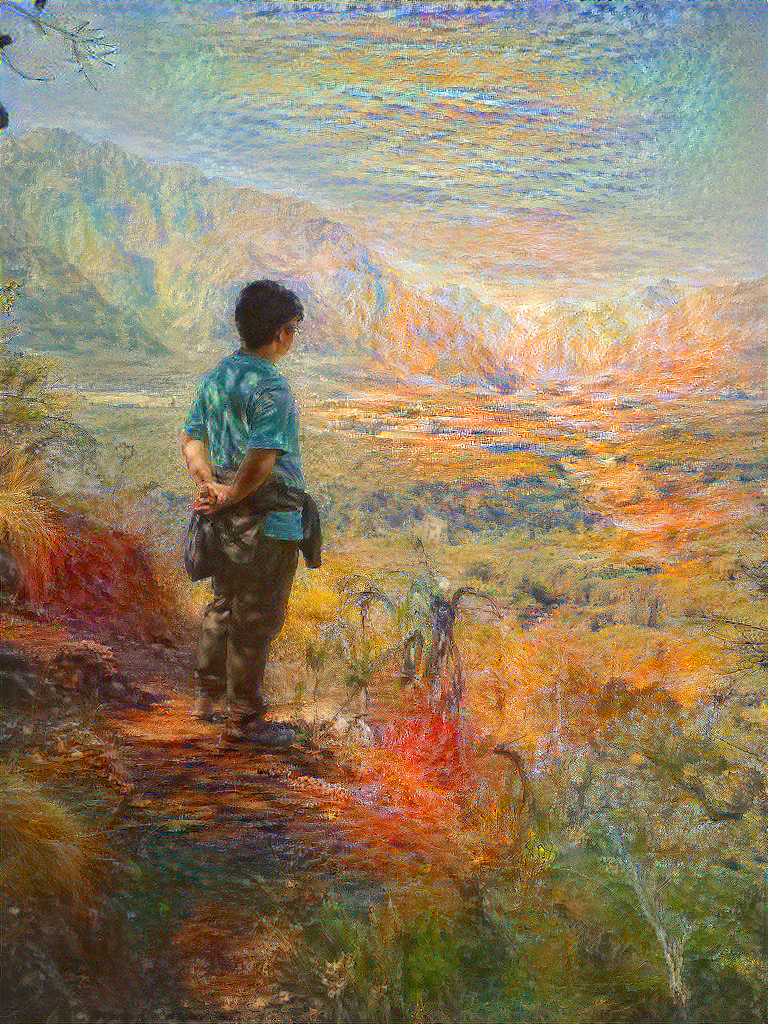

Paso numero: 1000
Tiempo Total: 233.0


In [24]:
import time
start = time.time()
step = 0
for n in range(fase):
    for m in range(pasosporfase):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(TensorAImagen(image))
    print("Paso numero: {}".format(step))
end = time.time()
print("Tiempo Total: {:.1f}".format(end-start))

Guardamos el resultado.

In [25]:
file_name = 'resultado.png'
TensorAImagen(image).save(file_name)